#### FTSE Global All Cap full basket 50 days pretrade comprehensive strategy

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import statsmodels.api as sm
from scipy.stats import zscore, rankdata

In [2]:
np.random.seed(22)
num_stocks = 300
num_days = 504  # 2021-01-01 到 2023-12-31 的交易日数（假设每年252天）

# 股票 sedol 列表
sedols = [f'SEDOL{i:06d}' for i in range(num_stocks)]
# 交易日
trading_days = pd.bdate_range('2021-01-01', '2023-12-31')

# 因子名
unique_descriptors = [
    'beta', 'momentum', 'size', 'value', 'volatility', 'liquidity', 'growth', 'leverage', 'profitability'
]

# 其他字段
other_fields = [
    'ret1', 'weight_ftse_globalall_cap', 'EV_rebal', 'event_action', 'country'
]

# 国家列表
countries = ['US', 'CN', 'JP', 'GB', 'DE']
# event_action 列表
event_actions = ['up', 'delete', 'up', 'down']

In [3]:
def random_df_with_missing_weights(rebalance_dates, num_stocks=300, num_days=504):
    np.random.seed(3)
    sedols = [f'SEDOL{i:06d}' for i in range(num_stocks)]
    trading_days = pd.bdate_range('2021-01-01', '2023-12-31')
    unique_descriptors = [
        'beta', 'momentum', 'size', 'value', 'volatility', 'liquidity', 'growth', 'leverage', 'profitability'
    ]
    other_fields = [
        'ret1', 'weight_ftse_globalall_cap', 'EV_rebal', 'event_action', 'country', 'close', 'volume'
    ]
    countries = ['US', 'CN', 'JP', 'GB', 'DE']
    event_actions = ['add', 'delete', '', 'rebalance']

    data = {}
    for desc in unique_descriptors:
        data[desc] = np.random.normal(-1, 1, (num_stocks, len(trading_days)))
    data['ret1'] = np.random.normal(-0.05, 0.05, (num_stocks, len(trading_days)))
    data['weight_ftse_globalall_cap'] = np.random.uniform(0, 0.05, (num_stocks, len(trading_days)))
    data['EV_rebal'] = np.random.uniform(-0.05, 0.05, (num_stocks, len(trading_days)))
    data['event_action'] = np.random.choice(event_actions, (num_stocks, len(trading_days)))
    data['country'] = np.random.choice(countries, (num_stocks, len(trading_days)))
    data['close'] = np.random.uniform(40, 50, (num_stocks, len(trading_days)))
    data['volume'] = np.random.uniform(100, 10000, (num_stocks, len(trading_days)))



    # 转为DataFrame
    dfs = {}
    for k in unique_descriptors + other_fields:
        sub_df = pd.DataFrame(
            data[k],
            index=sedols,
            columns=trading_days
        )
        dfs[k] = sub_df

    # 对每个event period，随机将几只股票的weight设为NaN
    for T in rebalance_dates:
        T_idx = dfs['weight_ftse_globalall_cap'].columns.get_loc(T)
        period_cols = dfs['weight_ftse_globalall_cap'].columns[T_idx-50:T_idx]  # T-50到T-1
        n_missing = np.random.randint(30, 60)  # 每个event随机3~7只股票缺失
        missing_stocks = np.random.choice(sedols, n_missing, replace=False)
        dfs['weight_ftse_globalall_cap'].loc[missing_stocks, period_cols] = np.nan

    return dfs, unique_descriptors

In [4]:
# 指定的rebalance_dates
rebalance_dates = pd.to_datetime([
    "2021-09-17", "2021-12-17", "2022-03-18", "2022-06-17", "2022-09-16"
])
dfs, unique_descriptors = random_df_with_missing_weights(rebalance_dates)
rebalance_dates = [d for d in rebalance_dates if d in dfs['EV_rebal'].columns]

from collections import namedtuple
CVSplit = namedtuple('CVSplit', ['train_dates', 'test_date'])

cv_splits = []
for test_date in rebalance_dates:
    train_dates = [d for d in rebalance_dates if d != test_date]
    cv_splits.append(CVSplit(train_dates=train_dates, test_date=test_date))

In [5]:
def get_tickers_at_T_minus_5(T, dfs):
    """
    输入:
        T: 当前event日期 (pd.Timestamp)
        dfs: 数据字典
    输出:
        tickers: list, T-5当天weight_ftse_globalall_cap非NaN的股票
        T_minus_5: T-5的日期
    """
    T_idx = dfs['weight_ftse_globalall_cap'].columns.get_loc(T)
    T_minus_5 = dfs['weight_ftse_globalall_cap'].columns[T_idx - 5]
    tickers = dfs['weight_ftse_globalall_cap'].index[
        dfs['weight_ftse_globalall_cap'][T_minus_5].notna()
    ].tolist()
    return tickers, T_minus_5

#### Feature Engineering

In [6]:
def get_snapshot_feature(T, tickers, dfs, feature_name):
    """
    T: 当前event日期
    tickers: T-5当天weight非NaN的股票
    feature_name: 某个barra因子名
    返回: DataFrame, shape=(tickers, 50)，T-50的barra值复制到50天
    """
    T_idx = dfs['weight_ftse_globalall_cap'].columns.get_loc(T)
    date_range = dfs['weight_ftse_globalall_cap'].columns[T_idx-50:T_idx]
    val = dfs[feature_name].loc[tickers, date_range[0]].values.reshape(-1, 1)
    df = pd.DataFrame(np.repeat(val, 50, axis=1), index=tickers, columns=date_range)
    return df
def get_timeseries_feature(T, tickers, dfs, feature_name):
    """
    返回: DataFrame, shape=(tickers, 50)，T-50到T-1每天的barra值
    """
    T_idx = dfs['weight_ftse_globalall_cap'].columns.get_loc(T)
    date_range = dfs['weight_ftse_globalall_cap'].columns[T_idx-50:T_idx]
    df = dfs[feature_name].loc[tickers, date_range]
    return df
def get_barra_trend_feature(T, tickers, dfs, feature_name):
    """
    返回: DataFrame, shape=(tickers, 50)，T-50到T-1每天barra值减去过去10天均值
    """
    T_idx = dfs['weight_ftse_globalall_cap'].columns.get_loc(T)
    date_range = dfs['weight_ftse_globalall_cap'].columns[T_idx-50:T_idx]
    full_range = dfs['weight_ftse_globalall_cap'].columns[T_idx-59:T_idx]  # 取前10天用于rolling
    values = dfs[feature_name].loc[tickers, full_range]
    rolling_mean = values.rolling(window=10, axis=1, min_periods=1).mean()
    trend = values.iloc[:, -50:].values - rolling_mean.iloc[:, -50:].values
    df = pd.DataFrame(trend, index=tickers, columns=date_range)
    return df
def get_pv_alpha_feature(T, tickers, dfs):
    """
    返回: DataFrame, shape=(tickers, 50)，每一天的pv alpha
    """
    T_idx = dfs['weight_ftse_globalall_cap'].columns.get_loc(T)
    date_range = dfs['weight_ftse_globalall_cap'].columns[T_idx-50:T_idx]
    pv_alpha = np.zeros((len(tickers), 50))
    for i, t in enumerate(date_range):
        t_idx = dfs['weight_ftse_globalall_cap'].columns.get_loc(t)
        if t_idx < 60:
            pv_alpha[:, i] = np.nan
            continue
        range1 = dfs['weight_ftse_globalall_cap'].columns[t_idx-60:t_idx-30]
        range2 = dfs['weight_ftse_globalall_cap'].columns[t_idx-30:t_idx]
        vol1 = dfs['weight_ftse_globalall_cap'].loc[tickers, range1].sum(axis=1)
        vol2 = dfs['weight_ftse_globalall_cap'].loc[tickers, range2].sum(axis=1)
        pv_alpha[:, i] = (vol1 / vol2 - 1).values
    df = pd.DataFrame(pv_alpha, index=tickers, columns=date_range)
    return df
from sklearn.linear_model import LinearRegression

def get_beta_residual_feature(T, tickers, dfs):
    """
    返回: DataFrame, shape=(tickers, 50)，每一天的beta残差
    """
    T_idx = dfs['weight_ftse_globalall_cap'].columns.get_loc(T)
    date_range = dfs['weight_ftse_globalall_cap'].columns[T_idx-50:T_idx]
    residuals = np.zeros((len(tickers), 50))
    for i, t in enumerate(date_range):
        t_idx = dfs['weight_ftse_globalall_cap'].columns.get_loc(t)
        if t_idx < 30:
            residuals[:, i] = np.nan
            continue
        prev_30 = dfs['weight_ftse_globalall_cap'].columns[t_idx-30:t_idx]
        y = dfs['ret1'].loc[tickers, prev_30].mean(axis=1).values  # 每只股票的均值
        X = dfs['ret1'].loc[tickers, t].values.reshape(-1, 1)  # 所有股票当天
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        res = y - y_pred
        residuals[:, i] = res
    df = pd.DataFrame(residuals, index=tickers, columns=date_range)
    return df
def get_valid_matrix(T, tickers, dfs):
    """
    返回: DataFrame, shape=(tickers, 50)，T-50到T-1每天weight非NaN为1，否则为0
    """
    T_idx = dfs['weight_ftse_globalall_cap'].columns.get_loc(T)
    date_range = dfs['weight_ftse_globalall_cap'].columns[T_idx-50:T_idx]
    valid = dfs['weight_ftse_globalall_cap'].loc[tickers, date_range].notna().astype(int)
    return valid

import numpy as np
import pandas as pd
from scipy.stats import zscore

def compute_skew_feature(event_cache, test_idx, group_names=['add', 'delete', 'up', 'down']):
    """
    计算 skew feature，返回 shape=(n_tickers, 50) 的 DataFrame
    """
    n_days = 50
    # 1. 收集所有training event的group分布
    group_day_ret1 = {g: [[] for _ in range(n_days)] for g in group_names}
    for i, event in enumerate(event_cache):
        if i == test_idx:
            continue
        ret1 = event['ret1']  # DataFrame, index=tickers, columns=date_range
        event_action = event['event_action']  # DataFrame, index=tickers, columns=date_range
        ret1_arr = ret1.values
        event_action_arr = event_action.values
        for day in range(n_days):
            for g in group_names:
                mask = (event_action_arr[:, day] == g)
                group_day_ret1[g][day].extend(ret1_arr[mask, day])

    # 2. 对每个group、每一天的分布做z-score和median对齐
    group_day_zscore = {g: [] for g in group_names}
    group_day_median = {g: [] for g in group_names}
    for g in group_names:
        for day in range(n_days):
            arr = np.array(group_day_ret1[g][day])
            if len(arr) == 0:
                group_day_zscore[g].append(np.array([]))
                group_day_median[g].append(np.nan)
                continue
            z = zscore(arr, nan_policy='omit')
            med = np.nanmedian(z)
            if np.isnan(med) or med == 0:
                z_aligned = z
            else:
                z_aligned = z / med
            group_day_zscore[g].append(z_aligned)
            group_day_median[g].append(np.nanmedian(z_aligned))

    # 3. 计算skewness score, skew deviation, skewmultiplier
    skew_score = {g: [] for g in group_names}
    skew_deviation = {g: [] for g in group_names}
    skew_multiplier = {g: [] for g in group_names}
    for g in group_names:
        for day in range(n_days):
            arr = group_day_zscore[g][day]
            if len(arr) == 0:
                skew_score[g].append(np.nan)
                skew_deviation[g].append(np.nan)
                skew_multiplier[g].append(np.nan)
                continue
            pos_sum = np.nansum(arr[arr > 0])
            abs_sum = np.nansum(np.abs(arr))
            if abs_sum == 0:
                score = 50
            else:
                score = pos_sum / abs_sum * 100
            deviation = (score - 50) / 50
            multiplier = 0.6 if deviation < 0 else 0.5
            skew_score[g].append(score)
            skew_deviation[g].append(deviation)
            skew_multiplier[g].append(multiplier)

    # 4. 对test event每一天每只股票，查找其group和ret1 quantile
    test_event = event_cache[test_idx]
    tickers = test_event['tickers']
    ret1 = test_event['ret1'].values  # shape=(n_tickers, n_days)
    event_action = test_event['event_action'].values  # shape=(n_tickers, n_days)
    n_tickers = len(tickers)
    skew_feature = np.full((n_tickers, n_days), np.nan)

    for day in range(n_days):
        for g in group_names:
            mask = (event_action[:, day] == g)
            if not np.any(mask):
                continue
            arr = group_day_zscore[g][day]
            if len(arr) == 0:
                continue
            test_ret = ret1[mask, day]
            quantiles = np.array([
                (np.sum(arr < v) + 0.5 * np.sum(arr == v)) / len(arr) * 100 if len(arr) > 0 else np.nan
                for v in test_ret
            ])
            deviation = skew_deviation[g][day]
            multiplier = skew_multiplier[g][day]
            for idx, q in zip(np.where(mask)[0], quantiles):
                if np.isnan(q) or np.isnan(deviation) or np.isnan(multiplier):
                    continue
                if deviation >= 0:
                    final_score = q + (100 - q) * multiplier * deviation
                else:
                    final_score = q + q * multiplier * deviation
                skew_feature[idx, day] = final_score

    return pd.DataFrame(skew_feature, index=tickers, columns=test_event['date_range'])

#### Get Confidence, Notional, acc_return matrices

In [7]:
def get_confidence_matrix_from_feature_list(feature_list):
    """
    输入: feature_list, 每个元素为 shape=(tickers, 50) 的 DataFrame
    输出: confidence_matrix, shape=(tickers, 50)
    目前为所有特征标准化后直接累加
    """
    features_std = []
    for feat in feature_list:
        arr = feat.values
        arr = (arr - np.nanmean(arr)) / (np.nanstd(arr) + 1e-8)
        features_std.append(arr)
    confidence_matrix = np.nansum(features_std, axis=0)
    return confidence_matrix

In [8]:
def get_position_matrix_all_70(confidence_matrix):
    pos = np.zeros_like(confidence_matrix)
    pos[:, 0] = confidence_matrix[:, 0]
    return pos

def get_position_matrix_quantile(confidence_matrix):
    """
    现有的方法：前10%和后10%保持原confidence score值，其余为0
    """
    pos = np.zeros_like(confidence_matrix)
    n_days = confidence_matrix.shape[1]
    for i in range(n_days):
        scores = confidence_matrix[:, i]
        n_tickers = len(scores)
        if n_tickers < 10:
            continue
        idx = np.argsort(scores)
        top_n = int(np.ceil(n_tickers * 0.1))
        pos[idx[:top_n], i] = scores[idx[:top_n]]
        pos[idx[-top_n:], i] = scores[idx[-top_n:]]
    return pos

from sklearn.linear_model import LinearRegression
import numpy as np

def get_position_matrix_ml_per_day(test_idx, event_cache, feature_names, model_type='lr', alpha=0.05):
    """
    支持 'lr'（线性回归）、'rf'（随机森林）、'xgb'（XGBoost）
    返回: position_matrix, pvalues_matrix (仅LR有pvalue，其余为None)
    """
    test_event = event_cache[test_idx]
    n_tickers = len(test_event['tickers'])
    n_days = 50
    n_features = len(feature_names)
    pos = np.zeros((n_tickers, n_days))
    pvalues_matrix = np.full((n_features, n_days), np.nan) if model_type == 'lr' else None

    for day in range(n_days):
        # 组装训练集
        X_train, y_train = [], []
        for i, event in enumerate(event_cache):
            if i == test_idx:
                continue
            feats = [event['features'][fname][:, day] for fname in feature_names]
            X = np.column_stack(feats)
            y = event['EV_rebal'][:, day]
            X_train.append(X)
            y_train.append(y)
        X_train = np.vstack(X_train)
        y_train = np.concatenate(y_train)

        # 训练与预测
        if model_type == 'lr':
            import statsmodels.api as sm
            X_train_sm = sm.add_constant(X_train)
            model = sm.OLS(y_train, X_train_sm).fit()
            pvalues = model.pvalues[1:]  # 跳过截距
            pvalues_matrix[:, day] = pvalues
            # 预测
            test_feats = [test_event['features'][fname][:, day] for fname in feature_names]
            X_test = np.column_stack(test_feats)
            X_test_sm = sm.add_constant(X_test)
            pos[:, day] = model.predict(X_test_sm)
        elif model_type == 'rf':
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            test_feats = [test_event['features'][fname][:, day] for fname in feature_names]
            X_test = np.column_stack(test_feats)
            pos[:, day] = model.predict(X_test)
        elif model_type == 'xgb':
            import xgboost as xgb
            model = xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
            model.fit(X_train, y_train)
            test_feats = [test_event['features'][fname][:, day] for fname in feature_names]
            X_test = np.column_stack(test_feats)
            pos[:, day] = model.predict(X_test)
        else:
            raise ValueError("model_type must be 'lr', 'rf', or 'xgb'")
    return pos, pvalues_matrix

def summarize_feature_significance(pvalues_matrix, feature_names, alpha=0.05, topn=5):
    """
    输出p<alpha比例最大的前topn个feature
    """
    total_days = pvalues_matrix.shape[1]
    sig_ratio = np.sum(pvalues_matrix < alpha, axis=1) / total_days
    # 排序
    sorted_idx = np.argsort(-sig_ratio)  # 降序
    n_output = min(topn, len(feature_names))
    print(f"Top {n_output} features with highest p<{alpha} ratio:")
    for i in range(n_output):
        idx = sorted_idx[i]
        print(f"{feature_names[idx]}: {sig_ratio[idx]:.2%} ({np.sum(pvalues_matrix[idx] < alpha)}/{total_days})")
    return [feature_names[idx] for idx in sorted_idx[:n_output]]

In [9]:
def get_initial_notional_matrix(tickers, T, dfs):
    """
    返回 shape = (tickers, 50) 的 notional 矩阵，T-50那天为1，其余为0
    """
    notional = np.zeros((len(tickers), 50))
    notional[:, 0] = 1  # T-50那天为第0列
    return notional

In [10]:
def calc_acc_return(notional_matrix, EV_rebal_matrix):
    """
    notional_matrix, EV_rebal_matrix: shape = (tickers, 50)
    返回 acc_return: shape = (tickers, 50)
    """
    return notional_matrix * EV_rebal_matrix

#### Get test result and print function

In [11]:
def print_stats_table(acc_return, notional_matrix, name="Model"):
    """
    acc_return, notional_matrix: shape = (tickers, 50)
    name: 模型名
    """
    buy_mask = notional_matrix > 0
    sell_mask = notional_matrix < 0
    total_mask = np.ones_like(notional_matrix, dtype=bool)

    def stats(arr, mask):
        vals = arr[mask]
        if len(vals) == 0:
            return [0, 0, 0, 0]
        return [np.sum(vals), np.mean(vals), np.max(vals), np.min(vals)]

    sell_profit = stats(acc_return, sell_mask)
    buy_profit = stats(acc_return, buy_mask)
    total_profit = stats(acc_return, total_mask)

    sell_count = stats(notional_matrix, sell_mask)
    buy_count = stats(notional_matrix, buy_mask)
    total_count = stats(notional_matrix, total_mask)

    import pandas as pd
    table = pd.DataFrame(
        [sell_count, buy_count, total_count, sell_profit, buy_profit, total_profit],
        index=['sell count', 'buy count', 'total count', 'sell profit', 'buy profit', 'total profit'],
        columns=['sum', 'mean', 'max', 'min']
    )
    print(f"\n==== {name} ====")
    print(table)
    return table

In [12]:
def event_stats_table(acc_return, notional_matrix, name="Model"):
    """
    acc_return, notional_matrix: shape = (tickers, 50)
    返回: DataFrame, index为统计项，columns为统计量
    """
    buy_mask = notional_matrix > 0
    sell_mask = notional_matrix < 0
    total_mask = ~np.isnan(notional_matrix)
    valid_mask = ~np.isnan(acc_return)

    def stat(arr, mask):
        vals = arr[mask & valid_mask]
        vals = vals[vals != 0]
        if len(vals) == 0:
            return [0, 0, 0, 0, 0, 0]
        return [
            np.sum(vals),
            np.mean(vals),
            np.median(vals),
            np.max(vals),
            np.min(vals),
            np.std(vals)
        ]

    # winrate: acc_return > 0
    def winrate(arr, mask):
        vals = arr[mask & valid_mask]
        if len(vals) == 0:
            print("Warning: No valid values for winrate")
            return [0, 0, 0, 0, 0, 0]
        
        converted = [1 if v > 0 else 0 if v < 0 else np.nan for v in vals]
        s = pd.Series(converted)
        return [
            np.nan,
            s.dropna().mean(),
            np.nan,
            np.nan,
            np.nan,
            s.dropna().std()
        ]
    sell_profit = stat(acc_return, sell_mask)
    buy_profit = stat(acc_return, buy_mask)
    total_profit = stat(acc_return, total_mask)

    sell_count = stat(notional_matrix, sell_mask)
    buy_count = stat(notional_matrix, buy_mask)
    total_count = stat(notional_matrix, total_mask)

    win_rate = winrate(acc_return, total_mask)

    table = pd.DataFrame(
        [sell_count, buy_count, total_count, sell_profit, buy_profit, total_profit, win_rate],
        index=['sell count', 'buy count', 'total count', 'sell profit', 'buy profit', 'total profit', 'win_rate'],
        columns=['sum', 'mean', 'median', 'max', 'min', 'std']
    )
    # print(f"\n==== {name} ====")
    # print(table)
    return table

In [13]:
def average_stats_table(table_list):
    """
    输入: table_list, 每个元素为单个event的DataFrame
    输出: 平均表格
    """
    stacked = np.stack([t.values for t in table_list], axis=0)
    mean_table = pd.DataFrame(
        np.nanmean(stacked, axis=0),
        index=table_list[0].index,
        columns=table_list[0].columns
    )
    print("\n==== Mean Table Across Events ====")
    print(mean_table)
    return mean_table

In [14]:
def calc_corr_timeseries(confidence_matrix, EV_rebal_matrix):
    """
    两个shape相同的矩阵，返回每天的相关性序列
    """
    corrs = []
    for i in range(confidence_matrix.shape[1]):
        x = confidence_matrix[:, i]
        y = EV_rebal_matrix[:, i]
        # 标准化
        x = (x - np.nanmean(x)) / (np.nanstd(x) + 1e-8)
        y = (y - np.nanmean(y)) / (np.nanstd(y) + 1e-8)
        mask = ~np.isnan(x) & ~np.isnan(y)
        if np.sum(mask) > 1:
            corrs.append(np.corrcoef(x[mask], y[mask])[0, 1])
        else:
            corrs.append(np.nan)
    return np.array(corrs)

In [15]:
def calc_winrate_timeseries(confidence_matrix, EV_rebal_matrix):
    winrates = []
    for i in range(confidence_matrix.shape[1]):
        x = confidence_matrix[:, i]
        y = EV_rebal_matrix[:, i]
        # 标准化
        x = (x - np.nanmean(x)) / (np.nanstd(x) + 1e-8)
        y = (y - np.nanmean(y)) / (np.nanstd(y) + 1e-8)
        mask = ~np.isnan(x) & ~np.isnan(y)
        if np.sum(mask) > 0:
            win = np.sign(x[mask]) == np.sign(y[mask])
            winrates.append(np.mean(win))
        else:
            winrates.append(np.nan)
    return np.array(winrates)

In [16]:
def calc_group_cum_return(acc_return, event_action_matrix, group_names):
    """
    acc_return: shape=(tickers, 50)
    event_action_matrix: shape=(tickers, 50), 每天每只股票的event_action
    group_names: list, e.g. ['add', 'delete', 'up', 'down']
    返回: dict, key为group, value为shape=(50,)的累计收益
    """
    group_cum = {}
    for group in group_names:
        mask = (event_action_matrix == group)
        group_cum[group] = np.nansum(acc_return * mask, axis=0)
    return group_cum

In [17]:
def calc_daily_return(acc_return):
    """
    acc_return: shape=(tickers, 50)
    返回: shape=(50,)的每天return
    """
    return np.nanmean(acc_return, axis=0)

def calc_max_drawdown(cum_returns):
    """
    cum_returns: shape=(50,)的累计收益
    返回: 最大回撤
    """
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = cum_returns - running_max
    return np.min(drawdown)

#### **Backtest Main Function**

In [18]:
# 假设你有如下 features
feature_names = ['beta_trend', 'barra_trend', 'pv_alpha', 'beta_residual']

# 先缓存所有event的特征、EV_rebal、tickers
event_cache = []
for split in cv_splits:
    T = split.test_date
    tickers, _ = get_tickers_at_T_minus_5(T, dfs)
    if len(tickers) == 0:
        continue
    T_idx = dfs['EV_rebal'].columns.get_loc(T)
    date_range = dfs['EV_rebal'].columns[T_idx-50:T_idx]
    # 计算所有feature
    features = {
        'beta_trend': get_barra_trend_feature(T, tickers, dfs, "beta").values,
        'barra_trend': get_barra_trend_feature(T, tickers, dfs, "momentum").values,
        'pv_alpha': get_pv_alpha_feature(T, tickers, dfs).values,
        'beta_residual': get_beta_residual_feature(T, tickers, dfs).values,
    }
    feature_list = [pd.DataFrame(features[fname]) for fname in feature_names]
    EV_rebal = dfs['EV_rebal'].loc[tickers, date_range].values
    event_action = dfs['event_action'].loc[tickers, date_range]
    ret1 = dfs['ret1'].loc[tickers, date_range]
    event_cache.append({
        'T': T,
        'tickers': tickers,
        'features': features,
        'EV_rebal': EV_rebal,
        "confidence_matrix": get_confidence_matrix_from_feature_list(feature_list),
        "event_action": event_action,
        "ret1": ret1,
        "date_range": date_range,
    })

In [20]:
stats_tables = []
corr_list = []
winrate_list = []
group_cum_list = []
daily_return_list = []
drawdown_list = []
notional_list = []
quantile_returns_list = []
all_pvalues = []

method = 'quantile'

for test_idx, test_event in enumerate(event_cache):
    T = test_event['T']
    tickers = test_event['tickers']
    if len(tickers) == 0:
        continue

    feature_names = ['beta_trend', 'barra_trend', 'pv_alpha', 'beta_residual']
    skew_feature = compute_skew_feature(event_cache, test_idx)
    # print(skew_feature)
    if method == 'quantile':
        confidence_matrix = event_cache[test_idx]["confidence_matrix"]
        position_matrix = get_position_matrix_quantile(confidence_matrix)
    elif method == 'all_70':
        confidence_matrix = event_cache[test_idx]["confidence_matrix"]
        position_matrix = get_position_matrix_all_70(confidence_matrix)
    elif method == 'lr' or method == 'rf' or method == 'xgb':
        position_matrix,pvalues_matrix = get_position_matrix_ml_per_day(test_idx, event_cache, feature_names, model_type = method)
        if pvalues_matrix is not None:
            all_pvalues.append(pvalues_matrix)
    notional_matrix = position_matrix
    notional_list.append(notional_matrix)
    T_idx = dfs['EV_rebal'].columns.get_loc(T)
    date_range = dfs['EV_rebal'].columns[T_idx-50:T_idx]
    EV_rebal_matrix = test_event['EV_rebal']
    acc_return = calc_acc_return(notional_matrix, EV_rebal_matrix)
    def calc_quantile_returns(notional_matrix, acc_return, n_quantiles=5):
        """
        计算非0位置按notional分组的return之和
        """
        # 获取非0位置
        non_zero_mask = notional_matrix != 0
        non_zero_notional = notional_matrix[non_zero_mask]
        non_zero_returns = acc_return[non_zero_mask]
        
        if len(non_zero_notional) == 0:
            return np.zeros(n_quantiles)
        
        # 按notional值分组
        quantiles = pd.qcut(non_zero_notional, n_quantiles, labels=False, duplicates='drop')
        quantile_returns = []
        
        for q in range(n_quantiles):
            mask = quantiles == q
            if np.sum(mask) > 0:
                quantile_return = np.sum(non_zero_returns[mask])
            else:
                quantile_return = 0
            quantile_returns.append(quantile_return)
        
        return np.array(quantile_returns)

    quantile_returns = calc_quantile_returns(notional_matrix, acc_return)
    quantile_returns_list.append(quantile_returns)
    # 统计表
    table = event_stats_table(acc_return, notional_matrix, name=f"Event {T}")
    stats_tables.append(table)

    # 相关性和胜率
    corr_list.append(calc_corr_timeseries(notional_matrix, EV_rebal_matrix)) # or confidence_matrix
    winrate_list.append(calc_winrate_timeseries(notional_matrix, EV_rebal_matrix))

    # 分组累计收益
    event_action_matrix = dfs['event_action'].loc[tickers, date_range].values
    group_names = ['add', 'delete', 'up', 'down']
    group_cum_list.append(calc_group_cum_return(acc_return, event_action_matrix, group_names))

    # 每天return和最大回撤
    daily_return = calc_daily_return(acc_return)
    daily_return_list.append(daily_return)
    drawdown_list.append(calc_max_drawdown(np.cumsum(daily_return)))
if method == 'lr':
    all_pvalues_array = np.stack(all_pvalues, axis=0)  # shape: (n_test, n_features, 50)
    mean_pvalues_matrix = np.nanmean(all_pvalues_array, axis=0)  # (n_features, 50)
    sig_count = summarize_feature_significance(mean_pvalues_matrix, feature_names, alpha=0.05, topn=5)
# 平均表格
mean_table = average_stats_table(stats_tables)

# 平均相关性和胜率
mean_corr = np.nanmean(np.stack([c for c in corr_list if c is not None]), axis=0)
mean_winrate = np.nanmean(np.stack([w for w in winrate_list if w is not None]), axis=0)

# 平均分组累计收益
mean_group_cum = {}
for group in group_names:
    mean_group_cum[group] = np.nanmean([g[group] for g in group_cum_list], axis=0)

# 平均每天return和最大回撤
mean_daily_return = np.nanmean(np.stack(daily_return_list), axis=0)
mean_drawdown = np.nanmean(drawdown_list)

# 存储所有event的每日持仓和流动性
all_position = []
all_liquidity = []

for idx, split in enumerate(cv_splits):
    T = split.test_date
    tickers, _ = get_tickers_at_T_minus_5(T, dfs)
    if len(tickers) == 0:
        continue

    notional_matrix = notional_list[idx]  # shape: (tickers, 50)
    T_idx = dfs['EV_rebal'].columns.get_loc(T)
    date_range = dfs['EV_rebal'].columns[T_idx-50:T_idx]

    # 1. 持仓：每天所有股票notional绝对值的和
    position = np.nansum(np.abs(notional_matrix), axis=0)  # shape: (50,)

    # 2. 流动性：notional绝对值之和 / (close*volume)之和
    # 这里假设 close=EV_rebal，volume=weight_ftse_globalall_cap
    close = dfs['close'].loc[tickers, date_range].values
    volume = dfs['volume'].loc[tickers, date_range].values
    dollar_volume = np.nansum(close * volume, axis=0)  # shape: (50,)
    liquidity = np.nansum(np.abs(notional_matrix), axis=0) / (dollar_volume + 1e-8)

    all_position.append(position)
    all_liquidity.append(liquidity)
# 平均
mean_position = np.nanmean(np.stack(all_position), axis=0)
mean_liquidity = np.nanmean(np.stack(all_liquidity), axis=0)

grouping_results = {
    'quantile_returns': quantile_returns_list,
    'model_name': 'Baseline Model'
}

with open('feature2.pkl', 'wb') as f:
    pickle.dump(grouping_results, f)


==== Mean Table Across Events ====
                      sum      mean    median       max       min       std
sell count   -4711.139742 -3.569298 -3.361594 -1.858243 -8.207414  1.011238
buy count     4462.952397  3.380611  3.187421  7.429350  2.002985  0.804461
total count   -248.187344 -0.094343  0.072371  7.429350 -8.207414  3.594023
sell profit      0.899646  0.000669 -0.000468  0.302716 -0.308516  0.108473
buy profit      -0.746956 -0.000576 -0.001203  0.288197 -0.305998  0.100970
total profit     0.152691  0.000047 -0.000677  0.309778 -0.324107  0.104846
win_rate              NaN  0.497744       NaN       NaN       NaN  0.500077


#### Plot to compare alpha performance

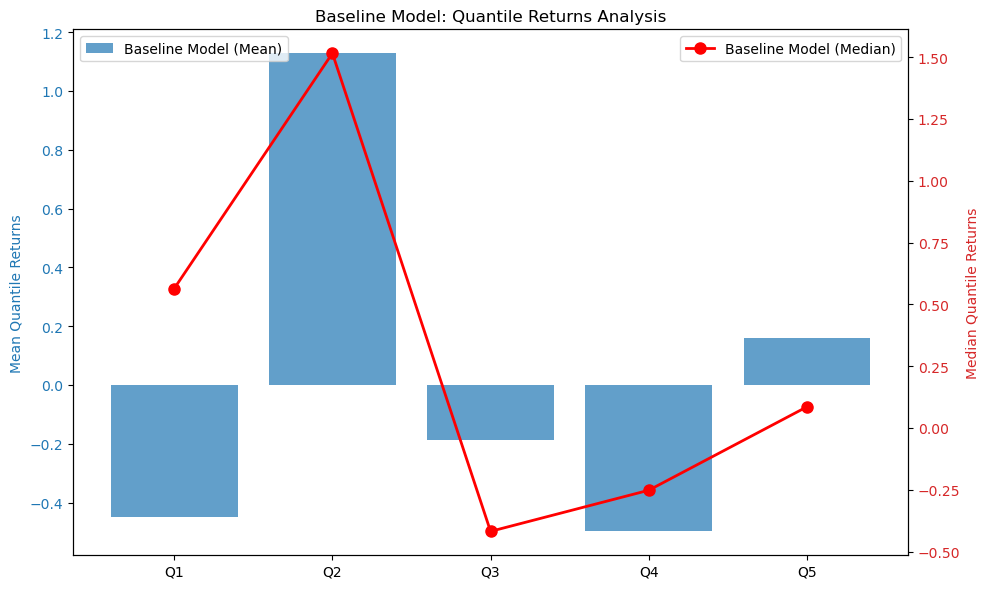

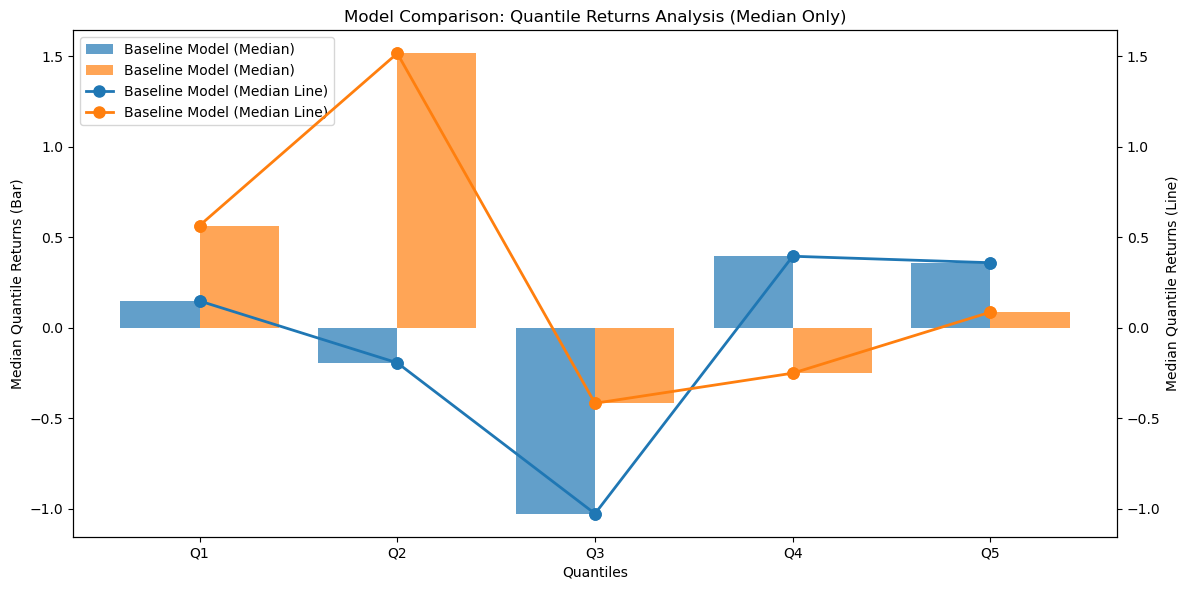

In [21]:
def plot_quantile_returns(quantile_returns_list, model_name="Model"):
    """
    画quantile分组return的bar plot + median折线图
    """
    # 计算平均和median
    quantile_array = np.stack(quantile_returns_list)
    mean_returns = np.mean(quantile_array, axis=0)
    median_returns = np.median(quantile_array, axis=0)
    
    x = np.arange(len(mean_returns))
    quantile_labels = [f'Q{i+1}' for i in range(len(mean_returns))]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # 左侧y轴：bar plot (mean)
    bars = ax1.bar(x, mean_returns, alpha=0.7, label=f'{model_name} (Mean)')
    ax1.set_ylabel('Mean Quantile Returns', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticks(x)
    ax1.set_xticklabels(quantile_labels)
    
    # 右侧y轴：median折线图
    ax2 = ax1.twinx()
    line = ax2.plot(x, median_returns, 'ro-', linewidth=2, markersize=8, 
                     label=f'{model_name} (Median)')
    ax2.set_ylabel('Median Quantile Returns', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # 图例
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title(f'{model_name}: Quantile Returns Analysis')
    plt.tight_layout()
    plt.show()
    
    return mean_returns, median_returns

# 使用
mean_returns, median_returns = plot_quantile_returns(quantile_returns_list, "Baseline Model")

def load_and_compare_models(model_files):
    """
    model_files: list of file paths, e.g. ['baseline_quantile_returns.pkl', 'ml_quantile_returns.pkl']
    """
    results = []
    for file in model_files:
        with open(file, 'rb') as f:
            results.append(pickle.load(f))
    return results

def plot_model_comparison(results):
    """
    results: list of dicts, each containing 'quantile_returns' and 'model_name'
    """
    n_models = len(results)
    n_quantiles = 5
    x = np.arange(n_quantiles)
    width = 0.8 / n_models  # bar宽度
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    
    for i, result in enumerate(results):
        quantile_array = np.stack(result['quantile_returns'])
        median_returns = np.median(quantile_array, axis=0)
        
        # bar plot (用median而不是mean)
        bars = ax1.bar(x + i*width, median_returns, width, 
                       alpha=0.7, label=f"{result['model_name']} (Median)",
                       color=colors[i % len(colors)])
        
        # median点 - 根据模型位置调整
        if i == 0:  # 第一组：bar右侧
            median_x = x + i*width + width/2
        else:  # 第二组及以后：bar左侧
            median_x = x + i*width - width/2
        
        ax1.plot(median_x, median_returns, 'o', color=colors[i % len(colors)], 
                 markersize=8) # label=f"{result['model_name']} (Median Point)"
    
    # 右侧y轴：median折线图
    ax2 = ax1.twinx()
    for i, result in enumerate(results):
        quantile_array = np.stack(result['quantile_returns'])
        median_returns = np.median(quantile_array, axis=0)
        
        # 根据模型位置调整点位置
        if i == 0:  # 第一组：bar右侧
            median_x = x + i*width + width/2
        else:  # 第二组及以后：bar左侧
            median_x = x + i*width - width/2
        
        line = ax2.plot(median_x, median_returns, 'o-', color=colors[i % len(colors)], 
                        linewidth=2, markersize=8, 
                        label=f"{result['model_name']} (Median Line)")
    
    ax1.set_ylabel('Median Quantile Returns (Bar)', color='black')
    ax2.set_ylabel('Median Quantile Returns (Line)', color='black')
    ax1.set_xlabel('Quantiles')
    ax1.set_xticks(x + width * (n_models-1) / 2)
    ax1.set_xticklabels([f'Q{i+1}' for i in range(n_quantiles)])
    
    # 合并图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title('Model Comparison: Quantile Returns Analysis (Median Only)')
    plt.tight_layout()
    plt.show()
model_files = [
    'feature1.pkl', 
    'feature2.pkl'
]
results = load_and_compare_models(model_files)
plot_model_comparison(results)

#### Plot to evaluate current alpha performance

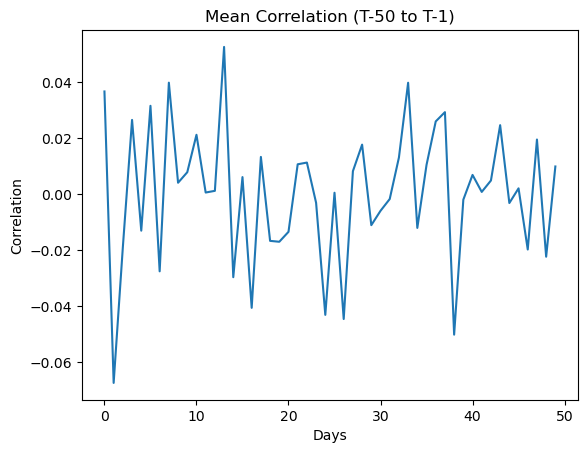

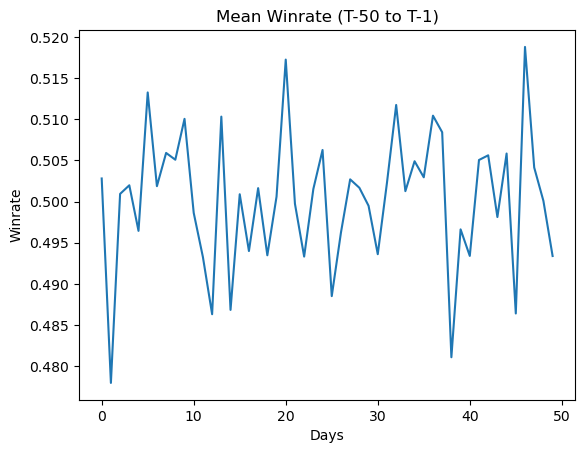

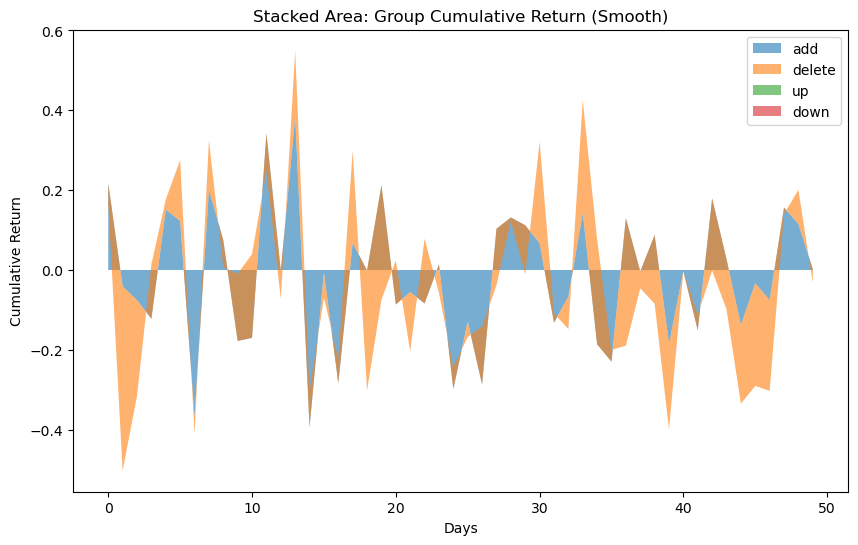

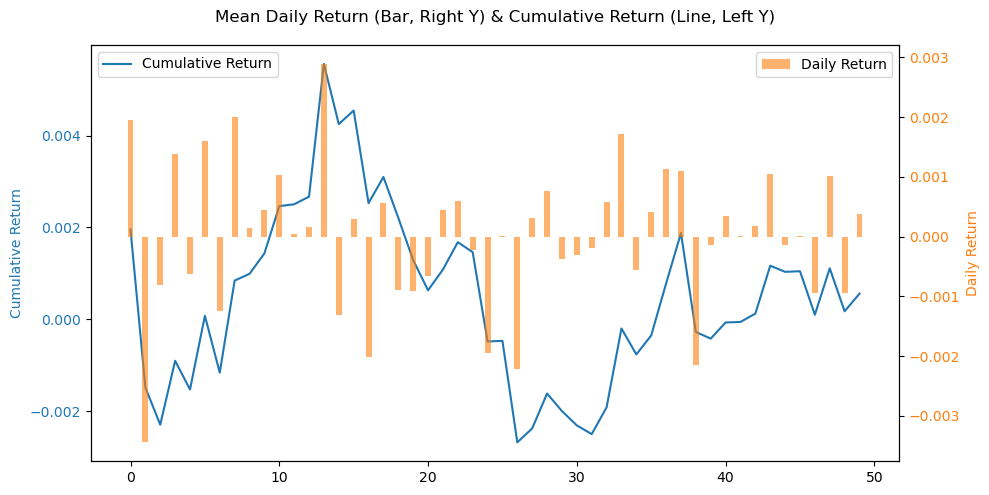

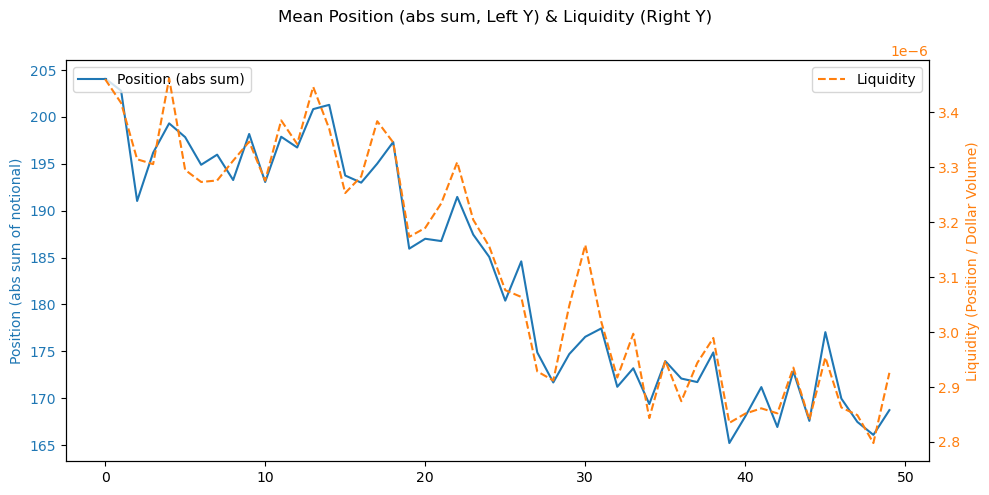

In [22]:
# 1. 相关性
plt.figure()
plt.plot(mean_corr)
plt.title("Mean Correlation (T-50 to T-1)")
plt.xlabel("Days")
plt.ylabel("Correlation")
plt.show()

# 2. 胜率
plt.figure()
plt.plot(mean_winrate)
plt.title("Mean Winrate (T-50 to T-1)")
plt.xlabel("Days")
plt.ylabel("Winrate")
plt.show()

# 3. 分组累计收益
# 假设 mean_group_cum 已经计算好
group_names = ['add', 'delete', 'up', 'down']
x = np.arange(50)

plt.figure(figsize=(10, 6))
bottom = np.zeros(50)

for group in group_names:
    y = mean_group_cum[group]
    plt.fill_between(x, bottom, bottom + y, label=group, alpha=0.6, 
                     linewidth=0)  # linewidth=0 让边缘更平滑
    bottom += y

plt.title("Stacked Area: Group Cumulative Return (Smooth)")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# 4. 每天return和最大回撤
x = np.arange(len(mean_daily_return))
cum_return = np.cumsum(mean_daily_return)

fig, ax1 = plt.subplots(figsize=(10, 5))

# 左侧y轴：累计收益
ax1.plot(x, cum_return, color='tab:blue', label='Cumulative Return')
ax1.set_ylabel('Cumulative Return', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 右侧y轴：每日收益
ax2 = ax1.twinx()
bar_width = 0.4  # 非常细的bar
ax2.bar(x, mean_daily_return, width=bar_width, color='tab:orange', alpha=0.6, label='Daily Return')
ax2.set_ylabel('Daily Return', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# 图例和标题
fig.suptitle("Mean Daily Return (Bar, Right Y) & Cumulative Return (Line, Left Y)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xlabel("Days (T-50 to T-1)")
plt.tight_layout()
plt.show()


# 5. 持仓和流动性
x = np.arange(len(mean_position))

fig, ax1 = plt.subplots(figsize=(10, 5))

# 左侧y轴：持仓
ax1.plot(x, mean_position, color='tab:blue', label='Position (abs sum)')
ax1.set_ylabel('Position (abs sum of notional)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 右侧y轴：流动性
ax2 = ax1.twinx()
ax2.plot(x, mean_liquidity, color='tab:orange', label='Liquidity', linestyle='--')
ax2.set_ylabel('Liquidity (Position / Dollar Volume)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# 图例和标题
fig.suptitle("Mean Position (abs sum, Left Y) & Liquidity (Right Y)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xlabel("Days (T-50 to T-1)")
plt.tight_layout()
plt.show()